In [229]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.cross_validation import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.cluster import KMeans

In [362]:
data = pd.read_csv('data/auto-mpg.data-original.txt', header=None,delim_whitespace=True)

In [363]:
cols = ['mpg','cylinders','displacement','horsepower','weight','acceleration','year','origin','name']

In [364]:
data.columns = cols

In [365]:
data = data.dropna().reset_index(drop=True)
data['year'] = (1900 + data['year']).astype(int)

In [366]:
data.ix[:,:5] = data.ix[:,:5].astype(int)
data['origin'] = data['origin'].astype(int)

# Predicting acceleration

In [520]:
regressors = data[['mpg','displacement','horsepower','weight']]

In [521]:
normalized_regressors = (regressors - regressors.mean()) / regressors.std()

In [522]:
normalized_regressors = sm.add_constant(normalized_regressors)

In [523]:
regressand = data['acceleration']

In [524]:
normalized_regressand = (regressand - regressand.mean()) / regressand.std()

In [525]:
lr = LinearRegression(fit_intercept=False)

In [526]:
lr.fit(normalized_regressors, normalized_regressand)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=1, normalize=False)

In [495]:
data['predicted_acceleration'] = lr.predict(regressors)

ValueError: shapes (392,4) and (5,) not aligned: 4 (dim 1) != 5 (dim 0)

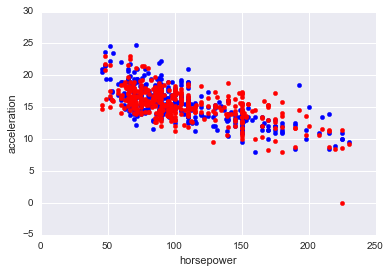

In [496]:
fig, ax = plt.subplots()
ax.scatter(data['horsepower'], data['acceleration'], color='b')
ax.scatter(data['horsepower'], data['predicted_acceleration'], color='r')
ax.set_xlabel('horsepower')
ax.set_ylabel('acceleration')

In [497]:
mean_squared_error(regressand, data['predicted_acceleration'])

4.9286360329886998

In [527]:
theta = lr.coef_

In [528]:
theta

array([  6.32522962e-15,  -6.22924562e-03,  -3.80738458e-01,
        -1.16665949e+00,   9.41807520e-01])

In [529]:
def cost_function(theta, x, y):
    theta = np.array(theta)
    x = np.array(x)
    y = np.array(y)
    J = 0
    m = len(x)
    for i in range(m):
        h = np.sum(theta.T * x[i])
        diff = (h - y[i])**2
        J += diff
    J /= (2 * m)
    return J

In [530]:
def partial_derivative_cost(theta, j, x, y):
    theta = np.array(theta)
    x = np.array(x)
    y = np.array(y)
    J = 0
    m = len(x)
    for i in range(m):
        h = np.sum(theta.T * x[i])
        diff = (h - y[i]) * x[i][j]
        J += diff
    J /= m
    return J

In [562]:
def gradient_descent(theta, x, y, alpha=0.1):
    #max number of iterations
    max_epochs = 10000
    #initaiting a count number so once reaching max iterations will termiante
    count = 0
    #convergence threshold
    conv_thres = 0.00000001
    #initail cost
    cost = cost_function(theta, x, y)
    prev_cost = cost + 10
    costs = [cost]
    thetas = [theta]
    
    #beginning gradient_descent iterations
    
    while (np.abs(prev_cost - cost) > conv_thres) and (count <= max_epochs):
        prev_cost = cost
        update = np.ones(len(theta))
        #simutaneously update all thetas
        for j in range(len(theta)):
            update[j] = alpha * partial_derivative_cost(theta, j, x, y)
        
        theta -= update
        
        thetas.append(theta)
        
        cost = cost_function(theta, x, y)
        
        costs.append(cost)
        count += 1
        
    return theta, costs

In [563]:
theta

array([  6.32522962e-15,  -6.22924562e-03,  -3.80738458e-01,
        -1.16665949e+00,   9.41807520e-01])

In [564]:
cost_function(theta, normalized_regressors, normalized_regressand)

0.19156988668169062

In [565]:
new_theta, cost_set = gradient_descent([1,1,1,1,1], normalized_regressors, normalized_regressand)

In [566]:
new_theta

array([  6.06713138e-15,  -6.73407569e-03,  -3.76865266e-01,
        -1.16771904e+00,   9.38487063e-01])

In [567]:
cost_function(new_theta, normalized_regressors, normalized_regressand)

0.19157070798047163

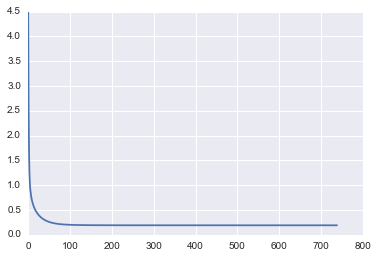

In [568]:
plt.plot(range(len(cost_set)), cost_set)

In [384]:
residuals = - data['acceleration'] + data['predicted_acceleration']

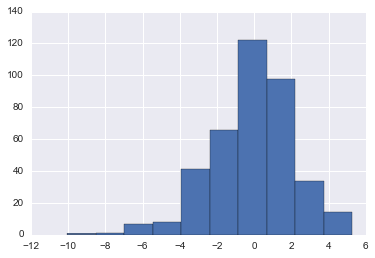

In [385]:
residuals.hist()

In [386]:
r2 = r2_score(data['acceleration'], data['predicted_acceleration'])

In [387]:
mse = mean_squared_error(data['acceleration'], data['predicted_acceleration'])

In [388]:
mse

4.9286360329886998

# Multiclass Classifier on Origin

In [17]:
dummy_cylinders = pd.get_dummies(data['cylinders'], prefix='cyl')

In [18]:
dummy_years = pd.get_dummies(data['year'], prefix='y')

In [19]:
dummies = pd.concat([dummy_cylinders, dummy_years], axis=1)

In [20]:
data = data.join(dummies)

In [21]:
categorical_cols = [col for col in data.columns if col.startswith('y_') or col.startswith('cyl_')]

In [22]:
x_train, x_test, y_train, y_test = train_test_split(data[categorical_cols],data['origin'],test_size=.2, random_state=1)

In [23]:
models = dict()
unique_origins = data['origin'].unique()
testing_probs = pd.DataFrame(columns = unique_origins)

In [24]:
for i in unique_origins:
    classifier = LogisticRegression()
    x = x_train
    y = y_train == i
    classifier.fit(x, y)
    models[i] = classifier
    testing_probs[i] = models[i].predict_proba(x_test)[:,1]

In [25]:
test_set = x_test.join(y_test).reset_index(drop=True)

In [26]:
predictions = testing_probs.idxmax(axis=1)

In [27]:
test_set['predicted_origin'] = predictions

In [28]:
correct = test_set['origin'] == test_set['predicted_origin']

In [29]:
len(test_set[correct]) / len(test_set)

0.759493670886076

In [30]:
probs = pd.DataFrame(columns = unique_origins)

In [31]:
for i in unique_origins:
    probs[i] = models[i].predict_proba(data[categorical_cols])[:,1]

In [32]:
data['predicted_origin'] = probs.idxmax(axis=1)

In [33]:
len(data[data['origin'] == data['predicted_origin']]) / len(data)

0.7142857142857143

# Clustering Cars

In [34]:
data = data[[i for i in data.columns if (i not in dummies.columns) and (i not in ['cylinders','year'])]]

In [35]:
data['hw_ratio'] = data['horsepower'] / data['weight']

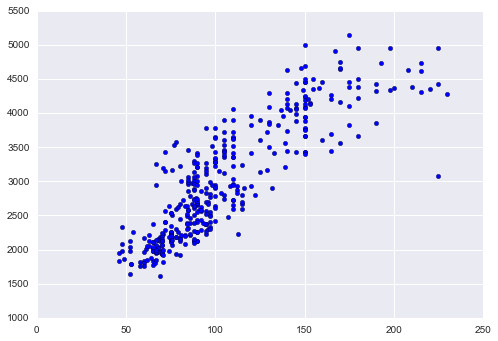

In [36]:
plt.scatter(data['horsepower'], data['weight'])

In [37]:
clustering = KMeans(n_clusters=3, random_state=1)

In [38]:
clustering.fit(data[['horsepower','weight']])

KMeans(copy_x=True, init='k-means++', max_iter=300, n_clusters=3, n_init=10,
    n_jobs=1, precompute_distances='auto', random_state=1, tol=0.0001,
    verbose=0)

In [39]:
data['cluster'] = clustering.labels_

In [40]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

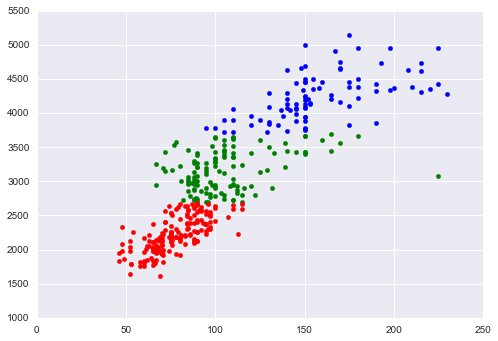

In [41]:
for n in range(3):
    clustered_data = data[data['cluster'] == n]
    plt.scatter(clustered_data['horsepower'], clustered_data['weight'], color=colors[n])

In [42]:
legend = {1:'North America', 2: 'Europe', 3:'Asia'}

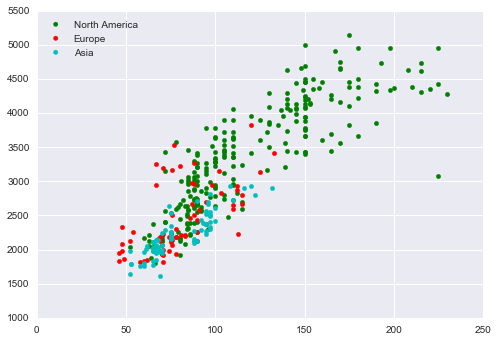

In [43]:
for n in range(1,4,1):
    clustered_data = data[data['origin'] == n]
    plt.scatter(clustered_data['horsepower'], clustered_data['weight'], color=colors[n], label=legend[n])
plt.legend(loc=2)